In [57]:
import os
from datetime import datetime
import sys
sys.path.append("../scripts/twitter")
import utils as ut

from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re
from math import ceil

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn import over_sampling
from imblearn import under_sampling

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

sf_df_raw = concat_data('../data/san_francisco/')

# Turn into a TwitterDataFrame and zoom in on san francisco
sf_df_raw = TwitterDataFrame(sf_df_raw)

sf_df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_8280/3815770650.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [30]:
sf_df_raw = sf_df_raw.dropna()

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)

In [31]:
sf_df = sf_df.group_by_days_and_batch(100)

sf_df.head()

,date,text
0,2018-05-01,Let’s bring back Double Dutch! Kinda sucks for...
1,2018-05-01,@DumbFlotrack @BlueVennDW @GoSydGo Of course h...
2,2018-05-01,@screaminggina @SaysDana @gametheorytoday Ever...
3,2018-05-01,Our quest to find out where each mayoral candi...
4,2018-05-01,tryna squad out to a Giants game the week of m...


In [32]:
sf_df.shape

(18136, 2)

In [5]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  8156
Per day : 22.345205479452055


In [6]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

AttributeError: 'DataFrame' object has no attribute 'count_by_day'

<Figure size 576x360 with 0 Axes>

In [33]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_8280/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [34]:
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

sf_mrg.head()

,date,text,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,2018-05-01,Let’s bring back Double Dutch! Kinda sucks for...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
1,2018-05-01,@DumbFlotrack @BlueVennDW @GoSydGo Of course h...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
2,2018-05-01,@screaminggina @SaysDana @gametheorytoday Ever...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
3,2018-05-01,Our quest to find out where each mayoral candi...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
4,2018-05-01,tryna squad out to a Giants game the week of m...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1


In [35]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')

stemmer = SnowballStemmer('english')

def process_tweet(tweet):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

sf_mrg['text'] = sf_mrg['text'].apply(process_tweet)

In [36]:
sf_mrg.to_csv("../data/san_francisco/sf_cleaned.csv")

In [37]:
train_df, test_df = train_test_split(sf_mrg, test_size=0.2, random_state=23)

In [12]:
vocab_size = 100000

emb_size = 100 # glove vectors are 100 dim

tweet_len = 5000 # tweets are all standardized to 40 words long

In [74]:
tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='?')
tokenizer.fit_on_texts(train_df['text'])

word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=tweet_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=tweet_len)

X_train.shape, X_test.shape, len(word_index)

((14508, 1000), (3628, 1000), 566400)

In [73]:
enc = OneHotEncoder().fit(train_df['Category'].to_numpy().reshape((-1, 1)))
y_train = enc.transform(train_df['Category'].to_numpy().reshape((-1, 1))).todense()
y_test = enc.transform(test_df['Category'].to_numpy().reshape((-1, 1))).todense()

y_train.shape, y_test.shape

((14508, 5), (3628, 5))

In [75]:
X_train, y_train = over_sampling.RandomOverSampler('not majority').fit_resample(X_train, y_train)
#X_train, y_train = under_sampling.RandomUnderSampler('majority').fit_resample(X_train, y_train)

C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
y_train.sum(axis=0)

array([11334, 11334, 11334, 11334, 11334])

In [42]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('../data/glove.twitter.27B.100d.txt')

1193514 words loaded


In [43]:
# Generate embedding layer for ml model
embedding_matrix = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
  if i >= vocab_size:
    break
  embedding_vector = glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [77]:
cnn_model = keras.models.Sequential()

embed_layer = keras.layers.Embedding(vocab_size, emb_size, weights=[embedding_matrix], input_length=tweet_len, trainable=False)
cnn_model.add(embed_layer)
cnn_model.add(keras.layers.SpatialDropout1D(0.10))
cnn_model.add(keras.layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(2))
cnn_model.add(keras.layers.Conv1D(64, 5, activation='relu'))
cnn_model.add(keras.layers.GlobalAveragePooling1D())
cnn_model.add(keras.layers.Dense(32, activation = "relu"))
cnn_model.add(keras.layers.Dense(5, activation="softmax")) 

cnn_model.summary()

cnn_model.summary()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         10000000  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 1000, 100)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 494, 64)           41024     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [78]:
history = cnn_model.fit(X_train, y_train, batch_size=512, epochs=1, validation_data=(X_test, y_test), callbacks=callbacks)
#cnn_model = keras.models.load_model('../data/models/final_model.h5')

111/111 [==============================] - 427s 4s/step - loss: 1.3990 - accuracy: 0.3898 - val_loss: 1.3285 - val_accuracy: 0.3630


In [79]:
cnn_model.save('../data/models/model_batch_resample.h5')

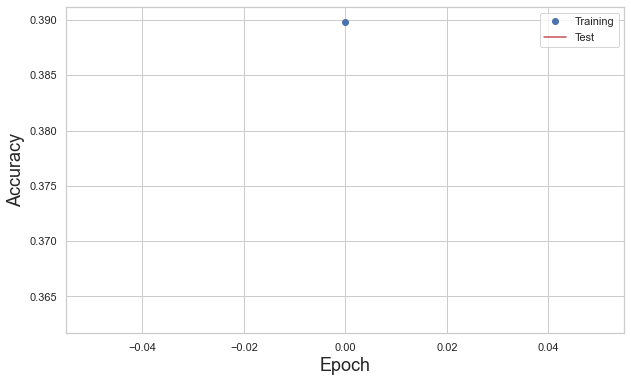

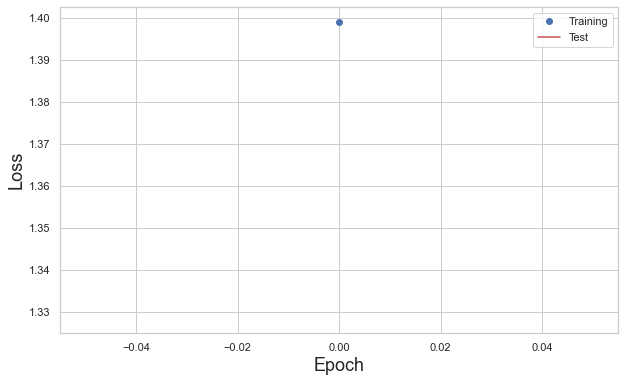

In [80]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(len(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracy, 'bo', label='Training')
plt.plot(epoch_range, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, loss, 'bo', label='Training')
plt.plot(epoch_range, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

In [81]:
y_pred = cnn_model.predict(X_test)

In [82]:
y_test_ = np.argmax(y_test, axis = 1)
y_pred_ = np.argmax(y_pred, axis = 1)


accuracy_score(y_test_, y_pred_), balanced_accuracy_score(y_test_, y_pred_)

(0.3630099228224917, 0.5692168321866109)

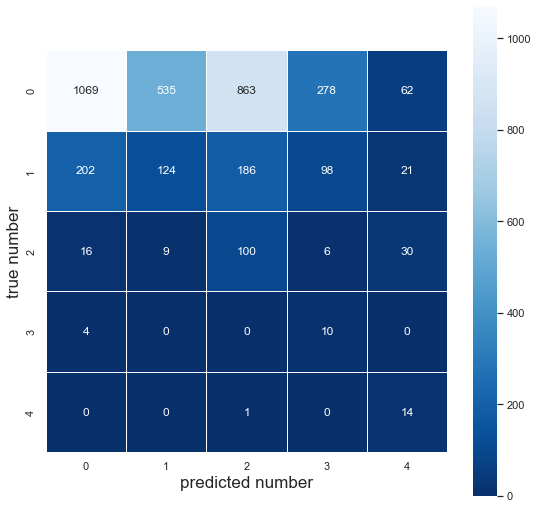

In [83]:
cm1 = confusion_matrix(y_test_, y_pred_)

plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true number', size=17)
plt.xlabel('predicted number', size=17)
plt.show()

